In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
from typing import List

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data

from scripts.zip_handler import ModelSizeZipHandler
from scripts.collector import BROModelScalingCollector
from scripts.core.preprocess import (
    truncate,
    manual_metrics,
)
from scripts.constants import DEFAULT_MAX_STEPS
from scripts.core.fitting import fit_regression
from scripts.experiments.utd_width_x_bs_lr_1d.plot_utils import (
    plot_metric_over_training_bs_per_env,
)
from scripts.experiments.utd_x_width_x_bs.plot_utils import (
    plot_metric_summary_vs_batch_size_group_utd,
    plot_metric_summary_vs_batch_size_group_width,
    plot_metric_summary_vs_width_group_batch_size,
)

import qscaled

qscaled.constants.suppress_overwrite_prompt = True

In [ ]:
main_collector = BROModelScalingCollector(
    'prestonfu',
    'BRO_model_scaling',
    use_cached=True,
)
main_collector.remove_short()
collector = main_collector.filter('learning_rate==3e-4').flatten()

In [4]:
@dataclass(kw_only=True)
class ModelSizeSweepConfig(BaseConfig):
    utds_to_predict: List[float]  # UTDs to predict hyperparams for
    model_sizes_to_predict: List[int]


config_input_dict = dict(
    max_returns={},
    returns_key='return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16, 32],
    model_sizes_to_predict=[128, 256, 512, 1024, 2048, 4096],
    thresholds=[],  # placeholder
)

config = ModelSizeSweepConfig(
    name='model_scaling_const_lr',  # Zip filename
    wandb_collector=collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS

In [6]:
# Fetch the data
df = fetch_zip_data(config, use_cached=True)

In [7]:
df = truncate(df, truncate_steps)
powers_of_two = [2**i for i in range(1, 15)]
df = df.query(f'utd in [1,2,4,8] and batch_size in {powers_of_two}')
df = df.query(
    'hard_target_update == False and target_noise_kind == "none" and use_separate_critic == False'
)
df = manual_metrics(df)

In [8]:
metric_dict = {
    'return': {},
    'critic_loss': {},
    'validation_critic_loss': {'alias': 'validation_loss'},
    'validation_overfitting': {},
    'new_data_critic_loss': {'alias': 'new_data_loss'},
    'new_data_overfitting': {},
    'old_data_critic_loss': {'alias': 'old_data_loss'},
    'old_data_overfitting': {},
    'old_target_critic_loss': {'alias': 'old_target_loss'},
    'mean_critic_grad_var': {'alias': 'critic_grad_var', 'yscale': 'log'},
    'adam_mean_critic_grad_var': {'alias': 'adam_critic_grad_var', 'yscale': 'log'},
    'critic_gnorm': {},
    'critic_pnorm': {},
}

xmin, xmax = 50000, 1e6

In [10]:
df = df.query(
    'utd in [1,2,4,8] and ('
    '(env_name=="h1-crawl-v0" and critic_width in [256,512,1024,2048]) or '
    '(env_name=="h1-pole-v0" and critic_width in [256,512,1024,2048]) or '
    '(env_name=="h1-stand-v0" and critic_width in [256,512,1024,2048,4096]) or '
    '(env_name=="humanoid-stand" and critic_width in [128,256,512,1024,2048]))'
    # '(env_name=="dog-walk" and critic_width in [256,512,1024,2048]) or '
)

[256, 512, 1024, 2048]
[256, 512, 1024, 2048]
[256, 512, 2048]
[64, 128, 256, 512, 1024, 2048]
[64, 128, 256, 512, 1024, 2048]
[64, 256, 512, 1024, 2048]
[256, 512, 2048]
[64, 128, 256, 512, 1024, 2048]
[64, 128, 256, 512, 1024, 2048]
[64, 256, 512, 1024, 2048]
['h1-crawl-v0', 'h1-pole-v0', 'h1-stand-v0', 'humanoid-stand']


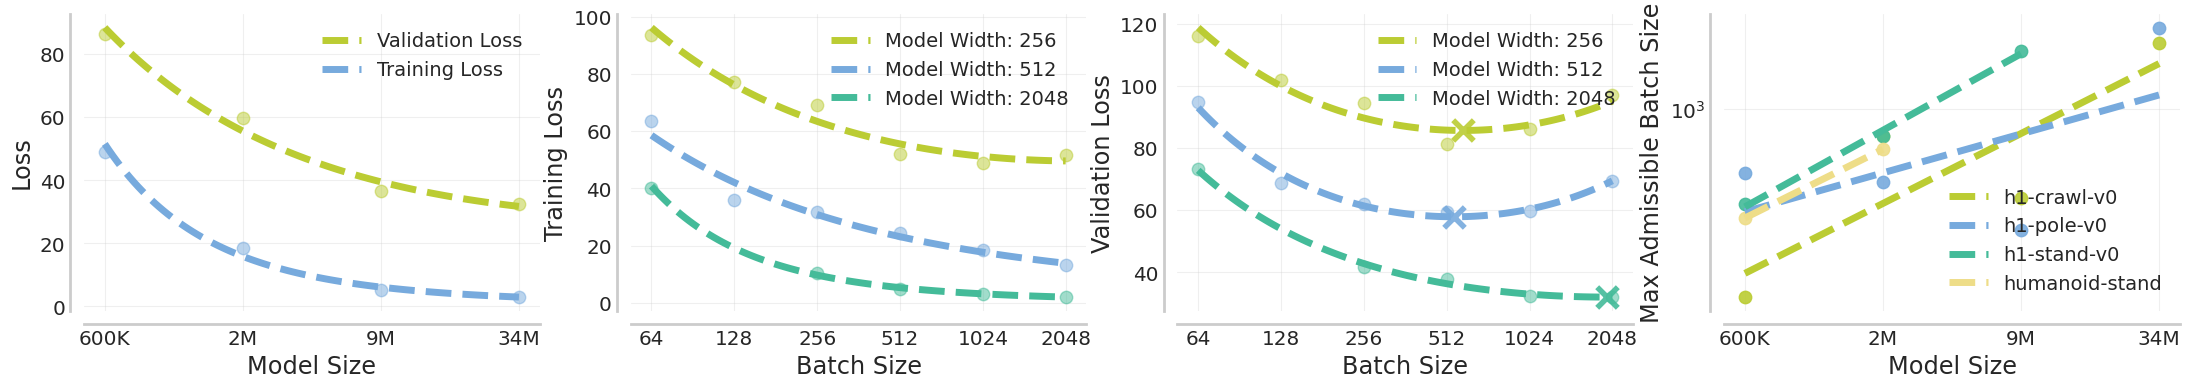

In [22]:
"""finalize rliable style plot
"""
import statsmodels.api as sm

"""data processing"""


def get_data(df, metric, summarize_how, filter_utd=None):
    df = deepcopy(df)
    if filter_utd is not None:
        df = df[df['utd'] == filter_utd]
    if summarize_how == 'end of training':
        if metric == 'return':
            df['summary'] = df[metric].apply(lambda x: x[-1])
        else:
            # Use np.nanmean to handle NaN values properly
            df['summary'] = df[metric].apply(lambda x: np.nanmean(x[-1, :]))
    elif summarize_how == 'mean over training':
        df['summary'] = df[metric].apply(lambda x: np.mean(x))
    elif summarize_how == 'median over training':
        df['summary'] = df[metric].apply(lambda x: np.median(x))
    elif summarize_how == 'last 10%':
        if metric == 'return':
            df['summary'] = df[metric].apply(lambda x: np.nanmean(x[-int(len(x) * 0.1) :]))
        else:
            df['summary'] = df[metric].apply(lambda x: np.nanmean(x[-int(len(x) * 0.1) :, :]))
    else:
        raise ValueError(f'Unknown summarize_how: {summarize_how}')

    envs = sorted(df['env_name'].unique())
    utds = sorted(df['utd'].unique())
    critic_widths = sorted(df['critic_width'].unique())
    batch_sizes = sorted(df['batch_size'].unique())

    return df, envs, utds, critic_widths, batch_sizes


training_loss_data, envs, utds, critic_widths, batch_sizes = get_data(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
        'and (critic_width<4096)'
        'and batch_size>8'
        'and utd==1'
    ),
    'critic_loss',
    summarize_how='last 10%',
    # filter_utd=2,
)

"""colors"""
# colors
from rliable import plot_utils

COLORS = [
    '#BBCC33',
    '#77AADD',
    '#44BB99',
    '#EEDD88',
    '#EE8866',
    '#FFAABB',
    '#99DDFF',
    '#44BB99',
    '#AAAA00',
    '#DDDDDD',
]
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{sansmath} \sansmath'  # Force sans-serif math mode (for axes labels)
)
plt.rcParams['font.family'] = 'sans-serif'  # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue']  # Choose a nice font here
sns.set_style('whitegrid')

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
n_colors = 3
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

"""plot"""
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(2596.0 / 192 * 2, 369.6 / 192 * 2)

"""ax[0]"""
idx = 0
# validation vs model size for utd 1, h1 pole + fit a line or a quadratic (1 curve)
# choose a constant batch size
batch_size = 1024

validation_loss_data, envs, utds, critic_widths, batch_sizes = get_data(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
        'and (critic_width<4096)'
        'and batch_size>8'
        'and utd==1'
    ),
    'validation_critic_loss',
    summarize_how='last 10%',
    # filter_utd=2,
)
# validation loss
validation_loss_df = validation_loss_data.query(
    f'env_name == "h1-pole-v0" and utd == 1 and batch_size =={batch_size}'
)

model_sizes = sorted(validation_loss_df['critic_width'].unique())
print(model_sizes)

x_values = []
y_values = []
for i, size in enumerate(model_sizes):
    subset = validation_loss_df[validation_loss_df['critic_width'] == size]
    x_values.append(size)
    y_values.append(subset['summary'].values[0])

    # scatter plot
    axes[idx].scatter(
        size, subset['summary'].values[0], marker='o', color=COLORS[0], alpha=0.5, s=80
    )

# fit a quadratic
x_values = np.array(x_values)
y_values = np.array(y_values)
log_x = np.log(x_values)
log_y = np.log(y_values)
X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
quad_fit = sm.OLS(log_y, X).fit()
smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
smooth_y = quad_fit.predict(X_smooth)

# plot the fit
axes[idx].plot(
    np.exp(smooth_x),
    np.exp(smooth_y),
    color=COLORS[0],
    linestyle='--',
    alpha=1,
    label='Validation Loss',
    linewidth=5,
)
axes[idx].legend(prop={'size': 14}, ncol=1, frameon=False, loc='upper right')
axes[idx].set_xscale('log')

# training loss
training_loss_df = training_loss_data.query(
    f'env_name == "h1-pole-v0" and utd == 1 and batch_size =={batch_size}'
)

model_sizes = sorted(training_loss_df['critic_width'].unique())
print(model_sizes)

x_values = []
y_values = []
for i, size in enumerate(model_sizes):
    subset = training_loss_df[training_loss_df['critic_width'] == size]
    x_values.append(size)
    y_values.append(subset['summary'].values[0])

    # scatter plot
    axes[idx].scatter(
        size, subset['summary'].values[0], marker='o', color=COLORS[1], alpha=0.5, s=80
    )

# fit a quadratic
x_values = np.array(x_values)
y_values = np.array(y_values)
log_x = np.log(x_values)
log_y = np.log(y_values)
X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
quad_fit = sm.OLS(log_y, X).fit()
smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
smooth_y = quad_fit.predict(X_smooth)

# plot the fit
axes[idx].plot(
    np.exp(smooth_x),
    np.exp(smooth_y),
    color=COLORS[1],
    linestyle='--',
    alpha=1,
    label='Training Loss',
    linewidth=5,
)
axes[idx].legend(prop={'size': 14}, ncol=1, frameon=False, loc='upper right')
axes[idx].set_xscale('log')
x = [256, 512, 1024, 2048]
# x_ticks_labels = [f'{int(x)}' for x in x]
model_params = ['600K', '2M', '9M', '34M']
x_ticks_labels = model_params
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, x_ticks_labels)

plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Model Size',
    ylabel='Loss',
    labelsize='xx-large',
    ticklabelsize='x-large',
    grid_alpha=0.3,
    legend=False,
)

"""ax[1]"""
idx = 1
# training vs batch size for utd 1, h1 pole for smallest and largest model size + fit a quadratic (2 curves)
training_loss_df = training_loss_data.query(
    'env_name == "h1-pole-v0" and utd == 1 and critic_width in [256, 512, 2048]'
)
model_sizes = sorted(training_loss_df['critic_width'].unique())
print(model_sizes)
for i, size in enumerate(model_sizes):
    subset = training_loss_df[training_loss_df['critic_width'] == size]
    batch_sizes = sorted(subset['batch_size'].unique())
    print(batch_sizes)

    x_values = []
    y_values = []

    for batch_size in batch_sizes:
        value = subset[subset['batch_size'] == batch_size]['summary'].values[0]
        x_values.append(batch_size)
        y_values.append(value)

        # scatter plot
        axes[idx].scatter(batch_size, value, marker='o', color=COLORS[i], alpha=0.5, s=80)

    # fit a quadratic
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    log_x = np.log(x_values)
    log_y = np.log(y_values)
    X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
    quad_fit = sm.OLS(log_y, X).fit()
    smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
    X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
    smooth_y = quad_fit.predict(X_smooth)

    # plot the fit
    axes[idx].plot(
        np.exp(smooth_x),
        np.exp(smooth_y),
        color=COLORS[i],
        linestyle='--',
        alpha=1,
        label=f'Model Width: {size}',
        linewidth=5,
    )

axes[idx].legend(prop={'size': 14}, ncol=1, frameon=False, loc='upper right')
axes[idx].set_xscale('log')

x = [64, 128, 256, 512, 1024, 2048]
x_ticks_labels = [f'{int(x)}' for x in x]
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, x_ticks_labels)

plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Batch Size',
    ylabel='Training Loss',
    labelsize='xx-large',
    ticklabelsize='x-large',
    grid_alpha=0.3,
    legend=False,
)


"""ax[2]"""
idx = 2
# validation vs batch size for utd 1, h1 pole for smallest and largest model size + fit a quadratic (2 curves)

validation_loss_df = validation_loss_data.query(
    'env_name == "h1-pole-v0" and utd == 1 and critic_width in [256, 512, 2048]'
)
model_sizes = sorted(validation_loss_df['critic_width'].unique())
print(model_sizes)
for i, size in enumerate(model_sizes):
    subset = validation_loss_df[validation_loss_df['critic_width'] == size]
    batch_sizes = sorted(subset['batch_size'].unique())
    print(batch_sizes)

    x_values = []
    y_values = []

    for batch_size in batch_sizes:
        value = subset[subset['batch_size'] == batch_size]['summary'].values[0]
        x_values.append(batch_size)
        y_values.append(value)

        # scatter plot
        axes[idx].scatter(batch_size, value, marker='o', color=COLORS[i], alpha=0.5, s=80)

    # fit a quadratic
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    log_x = np.log(x_values)
    log_y = np.log(y_values)
    X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
    quad_fit = sm.OLS(log_y, X).fit()
    smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
    X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
    smooth_y = quad_fit.predict(X_smooth)

    # plot the fit
    axes[idx].plot(
        np.exp(smooth_x),
        np.exp(smooth_y),
        color=COLORS[i],
        linestyle='--',
        alpha=1,
        label=f'Model Width: {size}',
        linewidth=5,
    )

    # get inflection point
    quad_coef = quad_fit.params[2]
    r2 = quad_fit.rsquared
    if quad_coef > 0:
        # Find the minimum of the quadratic fit
        if quad_coef > 0:  # Only if it's a U-shaped curve (positive quadratic term)
            # For a quadratic y = ax² + bx + c, the minimum is at x = -b/(2a)
            a, b = quad_fit.params[2], quad_fit.params[1]
            min_x_log = -b / (2 * a) if a != 0 else None

            # Check if minimum is within the data range
            if (
                min_x_log is not None
                and min_x_log >= np.log(subset['batch_size'].min())
                and min_x_log <= np.log(subset['batch_size'].max())
            ):
                min_x = np.exp(min_x_log)
                min_y = np.exp(quad_fit.predict([1, min_x_log, min_x_log**2])[0])

                # scatter plot
                axes[idx].scatter(
                    min_x, min_y, marker='x', color=COLORS[i], alpha=0.9, s=220, linewidths=4
                )

axes[idx].legend(prop={'size': 14}, ncol=1, frameon=False, loc='upper right')
axes[idx].set_xscale('log')

x = [64, 128, 256, 512, 1024, 2048]

x_ticks_labels = [f'{int(x)}' for x in x]
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, x_ticks_labels)

plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Batch Size',
    ylabel='Validation Loss',
    labelsize='xx-large',
    ticklabelsize='x-large',
    grid_alpha=0.3,
    legend=False,
)


"""ax[3]"""
# model size on x axis; inflection batch size on y axis;
# and colors for environments, utd=1, log scale, fit a line (just like the side critic plots)
idx = 3
envs = sorted(validation_loss_data['env_name'].unique())
print(envs)
for i, env in enumerate(envs):
    subset = validation_loss_data[validation_loss_data['env_name'] == env]
    # drop nan values in summary column
    subset = subset.dropna(subset=['summary'])
    model_sizes = sorted(subset['critic_width'].unique())

    inflection_x_values = []
    inflection_y_values = []

    for size in model_sizes:
        subsubset = subset[subset['critic_width'] == size]
        batch_sizes = sorted(subsubset['batch_size'].unique())

        # find the inflection point
        x_values = []
        y_values = []

        for batch_size in batch_sizes:
            value = subsubset[subsubset['batch_size'] == batch_size]['summary'].values[0]
            x_values.append(batch_size)
            y_values.append(value)

        # fit the quadratic to find the inflection point
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        log_x = np.log(x_values)
        log_y = np.log(y_values)
        X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
        quad_fit = sm.OLS(log_y, X).fit()
        smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
        X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
        smooth_y = quad_fit.predict(X_smooth)

        # get inflection point
        quad_coef = quad_fit.params[2]
        r2 = quad_fit.rsquared
        if quad_coef > 0:
            # Find the minimum of the quadratic fit
            if quad_coef > 0:  # Only if it's a U-shaped curve (positive quadratic term)
                # For a quadratic y = ax² + bx + c, the minimum is at x = -b/(2a)
                a, b = quad_fit.params[2], quad_fit.params[1]
                min_x_log = -b / (2 * a) if a != 0 else None

                # Check if minimum is within the data range
                if (
                    min_x_log is not None
                    and min_x_log >= np.log(subset['batch_size'].min())
                    and min_x_log <= np.log(subset['batch_size'].max())
                ):
                    min_x = np.exp(min_x_log)
                    min_y = np.exp(quad_fit.predict([1, min_x_log, min_x_log**2])[0])

                    inflection_x_values.append(size)
                    inflection_y_values.append(min_x)

                    # scatter plot
                    axes[idx].scatter(size, min_x, marker='o', color=COLORS[i], alpha=0.9, s=80)

    # fit a line for inflection points
    inflection_x_values = np.array(inflection_x_values)
    inflection_y_values = np.array(inflection_y_values)
    smooth_x = np.log(inflection_x_values)
    smooth_y = np.log(inflection_y_values)
    linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
    y_fit = linear_fit.predict(sm.add_constant(smooth_x))

    # plot the fit
    axes[idx].plot(
        np.exp(smooth_x),
        np.exp(y_fit),
        color=COLORS[i],
        linestyle='--',
        alpha=1,
        label=f'{env}',
        linewidth=5,
    )

axes[idx].legend(prop={'size': 14}, ncol=1, frameon=False, loc='lower right')
axes[idx].set_xscale('log')
axes[idx].set_yscale('log')

x = [256, 512, 1024, 2048]
model_params = ['600K', '2M', '9M', '34M']
x_ticks_labels = model_params
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, x_ticks_labels)

plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Model Size',
    ylabel='Max Admissible Batch Size',
    labelsize='xx-large',
    ticklabelsize='x-large',
    grid_alpha=0.3,
    legend=False,
)


plt.savefig('overfitting.pdf', dpi=300, bbox_inches='tight')

In [ ]:
"""prestonfu: not used anymore for averaging across envs"""

validation_loss_data, envs, utds, critic_widths, batch_sizes = get_data(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
        'and (critic_width<4096)'
        'and batch_size>8'
    ),
    'validation_critic_loss',
    summarize_how='last 10%',
    # filter_utd=2,
)

validation_loss_data = (
    validation_loss_data.groupby(['batch_size', 'utd', 'critic_width'])
    .mean(numeric_only=True)
    .reset_index()
)
utds = validation_loss_data['utd'].unique()
print(utds)

for i, utd in enumerate(utds):
    subset = validation_loss_data[validation_loss_data['utd'] == utd]
    model_sizes = sorted(subset['critic_width'].unique())

    # compute the inflection point for each model size, and plot it on y
    for size in model_sizes:
        x_values = []
        y_values = []

        subsubset = subset[subset['critic_width'] == size]
        batch_sizes = sorted(subsubset['batch_size'].unique())

        for batch_size in batch_sizes:
            value = subsubset[subsubset['batch_size'] == batch_size]['summary'].values[0]
            x_values.append(batch_size)
            y_values.append(value)

        x_values = np.array(x_values)
        y_values = np.array(y_values)
        log_x = np.log(x_values)
        log_y = np.log(y_values)
        X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
        quad_fit = sm.OLS(log_y, X).fit()
        smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
        X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
        smooth_y = quad_fit.predict(X_smooth)

        # get inflection point
        quad_coef = quad_fit.params[2]
        r2 = quad_fit.rsquared
        if quad_coef > 0:
            # Find the minimum of the quadratic fit
            if quad_coef > 0:  # Only if it's a U-shaped curve (positive quadratic term)
                # For a quadratic y = ax² + bx + c, the minimum is at x = -b/(2a)
                a, b = quad_fit.params[2], quad_fit.params[1]
                min_x_log = -b / (2 * a) if a != 0 else None

                # Check if minimum is within the data range
                if (
                    min_x_log is not None
                    and min_x_log >= np.log(subset['batch_size'].min())
                    and min_x_log <= np.log(subset['batch_size'].max())
                ):
                    min_x = np.exp(min_x_log)
                    min_y = np.exp(quad_fit.predict([1, min_x_log, min_x_log**2])[0])

                    # Plot X marker at the minimum
                    axes[idx].scatter(min_x, min_y, marker='o', color=COLORS[i], alpha=0.5, s=80)

In [ ]:
plot_metric_over_training_bs_per_env(df, 'critic_loss', {'yscale': 'log'}, xlim=(xmin, xmax))

In [ ]:
plot_metric_over_training_bs_per_env(
    df, 'validation_critic_loss', {'yscale': 'log'}, xlim=(xmin, xmax)
)

In [ ]:
"""prestonfu: filter out the poor returns (e.g. batch_size=2)"""
good_df = df.query('batch_size > 2')
plot_metric_over_training_bs_per_env(
    good_df, 'validation_critic_loss', {'yscale': 'log'}, xlim=(xmin, xmax)
)

In [ ]:
plot_metric_over_training_bs_per_env(
    df,
    'validation_overfitting',
    {'yscale': 'log', 'hard_ymin': 1},
    xlim=(xmin, xmax),
)

In [ ]:
fit_regression(df, 'mean_critic_loss')

In [ ]:
fit_regression(df, 'mean_validation_overfitting')

In [ ]:
def print_o_b_corr(df):
    # df['final_mean_validation_overfitting'] = df['mean_validation_overfitting'].apply(
    #     lambda x: x[-1]
    # )
    df['summary'] = df['mean_validation_overfitting'].apply(np.median)

    datas = []
    for (env, critic_width), group in df.groupby(['env_name', 'critic_width']):
        o_b_corr = np.corrcoef(group['summary'], group['batch_size'])[0, 1]
        datas.append({'env_name': env, 'critic_width': critic_width, 'o_b_corr': o_b_corr})
    df = pd.DataFrame(datas)
    display(df.pivot(index='critic_width', columns='env_name', values='o_b_corr'))
    for env in df['env_name'].unique():
        env_df = df[df['env_name'] == env]
        print(
            env,
            'corr(N, corr(overfitting, B)):',
            np.corrcoef(env_df['critic_width'], env_df['o_b_corr'])[0, 1],
        )


print_o_b_corr(df)

In [ ]:
def plot_o_b_corr_per_env_n_utd(df):
    # df['final_mean_validation_overfitting'] = df['mean_validation_overfitting'].apply(
    #     lambda x: x[-1]
    # )
    df['summary'] = df['mean_validation_overfitting'].apply(np.median)

    datas = []
    for (env, utd, critic_width), group in df.groupby(['env_name', 'utd', 'critic_width']):
        o_b_corr = np.corrcoef(group['summary'], group['batch_size'])[0, 1]
        datas.append(
            {'env_name': env, 'utd': utd, 'critic_width': critic_width, 'o_b_corr': o_b_corr}
        )
    results = pd.DataFrame(datas)

    envs = sorted(df['env_name'].unique())
    fig, axes = plt.subplots(1, len(envs), figsize=(len(envs) * 4, 4))
    for env, ax in zip(envs, axes.flatten()):
        subset = results[results['env_name'] == env]
        pivot = subset.pivot(index='critic_width', columns='utd', values='o_b_corr').sort_index(
            ascending=False
        )
        sns.heatmap(pivot, annot=True, fmt='.2f', ax=ax, vmin=-1, vmax=1)
        ax.set_title(env)
        ax.set_xlabel('UTD')
        ax.set_ylabel('critic width')
        ax.set_aspect('equal')
    plt.suptitle('corr(overfitting, batch size)', fontsize=14)
    plt.tight_layout()
    plt.show()


plot_o_b_corr_per_env_n_utd(df)

In [ ]:
plot_metric_summary_vs_batch_size_group_utd(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
    ),
    'mean_validation_overfitting',
    summarize_how='median over training',
    # filter_utd=2,
)

In [ ]:
"""prestonfu: plot validation loss, with batch_size as x"""
plot_metric_summary_vs_batch_size_group_utd(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
        'and (critic_width<4096)'
        'and batch_size>8'
        'and utd==1'
    ),
    'validation_critic_loss',
    summarize_how='last 10%',
    # filter_utd=2,
)

In [ ]:
"""prestonfu: plot training loss, with batch_size as x"""
plot_metric_summary_vs_batch_size_group_utd(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
        'and (critic_width<4096)'
        'and batch_size>8'
        'and utd==1'
    ),
    'critic_loss',
    summarize_how='last 10%',
    # filter_utd=2,
)

In [ ]:
plot_metric_summary_vs_batch_size_group_width(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
    ),
    'mean_validation_overfitting',
    summarize_how='median over training',
)

In [ ]:
plot_metric_summary_vs_batch_size_group_width(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024))'
    ),
    'mean_return',
    summarize_how='end of training',
)

In [ ]:
plot_metric_summary_vs_width_group_batch_size(
    df.query(
        '(critic_width>=256) and (env_name != "humanoid-stand" or (env_name == "humanoid-stand" and batch_size <= 1024)) and batch_size >= 32 and batch_size <= 2048'
    ),
    'mean_return',
    summarize_how='end of training',
)